<a href="https://colab.research.google.com/github/tuancompa2610/Unsupervised-Consumed-Finance-in-USA/blob/main/Unsupervised_Consumed_Finance_in_USA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Libraries

In [4]:
!pip install dash
!pip install jupyter_dash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.6 MB/s eta 0:00:00


In [19]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from dash import Input, Output, dcc, html
from jupyter_dash import JupyterDash
from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


In [13]:
from google.colab import files
uploaded = files.upload()

Saving scfp2019excel.zip to scfp2019excel.zip


# 2. Data Processing

In [14]:
df = pd.read_csv("/content/scfp2019excel.zip")
df.head()

,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,6119.779308,2,75,6,12,4,2,0,...,5,3,6,3,2,10,6,6,3,3
1,1,12,4712.374912,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
2,1,13,5145.224455,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
3,1,14,5297.663412,2,75,6,12,4,2,0,...,5,2,6,2,1,10,4,4,2,2
4,1,15,4761.812371,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2


In [20]:
prop_biz_owners = df["HBUS"].mean()
print("proportion of business owners in df:", prop_biz_owners)

proportion of business owners in df: 0.2740176562229531


In [21]:
inccat_dict = {
    1: "0-20",
    2: "21-39.9",
    3: "40-59.9",
    4: "60-79.9",
    5: "80-89.9",
    6: "90-100",
}

df_inccat = (
	df["INCCAT"]
    .replace(inccat_dict)
    .groupby(df["HBUS"])
    .value_counts(normalize = True)
    .rename("frequency")
    .to_frame()
    .reset_index()
)

df_inccat

,HBUS,INCCAT,frequency
0,0,0-20,0.210348
1,0,21-39.9,0.198140
2,0,40-59.9,0.189080
3,0,60-79.9,0.186600
4,0,90-100,0.117167
5,0,80-89.9,0.098665
6,1,90-100,0.629438
7,1,60-79.9,0.119015
8,1,80-89.9,0.097410
9,1,40-59.9,0.071510


# 3. EDA

Text(0.5, 1.0, 'Income Distribution: Business Owners vs. Non-Business Owners')

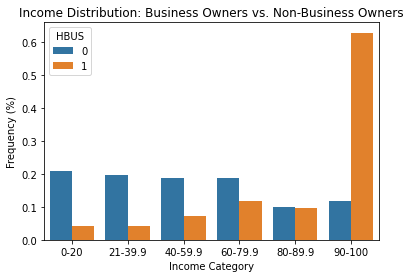

In [23]:
# Create bar chart of `df_inccat`
sns.barplot(
    x = "INCCAT",
    y = "frequency",
    data = df_inccat,
	hue = "HBUS",
    order = inccat_dict.values()
)
plt.xlabel("Income Category")
plt.ylabel("Frequency (%)")
plt.title("Income Distribution: Business Owners vs. Non-Business Owners")


Text(0.5, 1.0, 'Home Value vs. Household Debt')

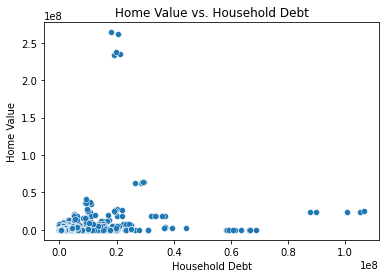

In [24]:
# Plot "HOUSES" vs "DEBT" with hue=label
sns.scatterplot(
	  x = "HOUSES",
    y = "DEBT",
    data = df
)
plt.xlabel("Household Debt")
plt.ylabel("Home Value")
plt.title("Home Value vs. Household Debt")


In [25]:
mask = (df["INCOME"] < 500_000) & (df["HBUS"] == 1)
df_small_biz = df[mask]
print("df_small_biz shape:", df_small_biz.shape)
df_small_biz.head()

df_small_biz shape: (4364, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
80,17,171,7802.265717,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
81,17,172,8247.536301,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
82,17,173,8169.562719,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
83,17,174,8087.704517,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
84,17,175,8276.510048,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4


Text(0.5, 1.0, 'Small Business Owners: Age Distribution')

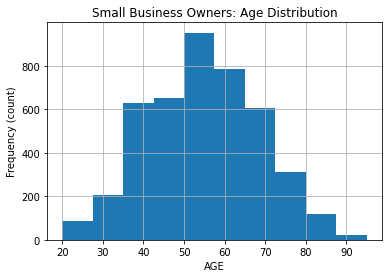

In [26]:
# Plot histogram of "AGE"
df_small_biz["AGE"].hist()
plt.xlabel("AGE")
plt.ylabel("Frequency (count)")
plt.title("Small Business Owners: Age Distribution")

In [27]:
# Calculate variance, get 10 largest features
top_ten_var = df_small_biz.var().sort_values().tail(10)
top_ten_var

EQUITY      1.005088e+13
FIN         2.103228e+13
KGBUS       5.025210e+13
ACTBUS      5.405021e+13
BUS         5.606717e+13
KGTOTAL     6.120760e+13
NHNFIN      7.363197e+13
NFIN        9.244074e+13
NETWORTH    1.424450e+14
ASSET       1.520071e+14
dtype: float64

In [28]:
# Calculate trimmed variance
top_ten_trim_var = df_small_biz.apply(trimmed_var, limits = (0.1, 0.1)).sort_values().tail(10)
top_ten_trim_var

EQUITY      1.177020e+11
KGBUS       1.838163e+11
FIN         3.588855e+11
KGTOTAL     5.367878e+11
ACTBUS      5.441806e+11
BUS         6.531708e+11
NHNFIN      1.109187e+12
NFIN        1.792707e+12
NETWORTH    3.726356e+12
ASSET       3.990101e+12
dtype: float64

In [30]:
# Create horizontal bar chart of `top_ten_trim_var`
fig = px.bar(
	x = top_ten_trim_var,
    y = top_ten_trim_var.index,
    title = "Small Business Owners: High Variance Features"
)
fig.update_layout(xaxis_title = "Trimmed Variance [$]", yaxis_title = "Feature")
fig.show()

In [31]:
high_var_cols = top_ten_trim_var.tail(5).index.to_list()
high_var_cols

['BUS', 'NHNFIN', 'NFIN', 'NETWORTH', 'ASSET']

In [32]:
X = df_small_biz[high_var_cols]
print("X shape:", X.shape)

X shape: (4364, 5)


# 4. KMean

In [33]:
n_clusters = range(2, 13)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for n in n_clusters:
    model = make_pipeline(StandardScaler(), KMeans(n_clusters = n, random_state = 42))
    model.fit(X)
    inertia_errors.append(model.named_steps["kmeans"].inertia_)
    silhouette_scores.append(silhouette_score(X, model.named_steps["kmeans"].labels_))

print("Inertia:", inertia_errors[:11])
print()
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [5765.86394936507, 3070.42944883576, 2220.292185089682, 1777.4635570665569, 1443.7860071034047, 1173.3701169575, 1004.0082329287359, 892.7197264630449, 780.7646441851743, 678.9317940468644, 601.0107062352749]

Silhouette Scores: [0.9542706303253067, 0.8446503900103915, 0.7422220122162623]


In [35]:
# Create line plot of `inertia_errors` vs `n_clusters`
fig = px.line(
	x = n_clusters,
    y = inertia_errors,
    title = "K-Means Model: Inertia vs Number of Clusters"
)
fig.update_layout(xaxis_title = "Number of Clusters", yaxis_title = "Inertia")
fig.show()

In [37]:
# Create a line plot of `silhouette_scores` vs `n_clusters`
fig = px.line(
	  x = n_clusters,
    y = silhouette_scores,
    title = "K-Means Model: Inertia vs Number of Clusters"
)
fig.update_layout(xaxis_title = "Number of Clusters", yaxis_title = "Silhouette Score")

fig.show()

In [38]:
final_model = make_pipeline(StandardScaler(), KMeans(n_clusters = 4, random_state =42))
final_model.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=4, random_state=42))])

Communicate

In [39]:
labels = final_model.named_steps["kmeans"].labels_
xgb = X.groupby(labels).mean()
xgb

,BUS,NHNFIN,NFIN,NETWORTH,ASSET
0,4.963323e+06,6.618360e+06,8.288328e+06,1.082102e+07,1.138241e+07
1,7.002168e+07,8.236493e+07,9.225990e+07,1.146303e+08,1.179872e+08
2,2.225482e+07,2.656204e+07,2.894737e+07,3.716900e+07,3.842715e+07
3,4.123688e+05,6.043267e+05,1.008566e+06,1.427448e+06,1.614814e+06


In [40]:
# Create side-by-side bar chart of `xgb`
fig = px.bar(
    xgb,
    barmode = "group",
    title = "Small Business Owner Finances by Cluster"
)
fig.update_layout(xaxis_title = "Cluster", yaxis_title = "Value [$]")

fig.show()

# 5. PCA

In [41]:
# Instantiate transformer
pca = PCA(n_components = 2, random_state = 42)

# Transform `X`
X_t = pca.fit_transform(X)

# Put `X_t` into DataFrame
X_pca = pd.DataFrame(X_t, columns = ["PC1", "PC2"])

print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca shape: (4364, 2)


,PC1,PC2
0,-6.220648e+06,-503841.638839
1,-6.222523e+06,-503941.888901
2,-6.220648e+06,-503841.638839
3,-6.224927e+06,-504491.429465
4,-6.221994e+06,-503492.598399


In [42]:
# Create scatter plot of `PC2` vs `PC1`
fig = px.scatter(
	  data_frame = X_pca,
    x = "PC1",
    y = "PC2",
    color = labels.astype(str),
    title = "PCA Representation of Clusters"
)
fig.update_layout(xaxis_title = "PC1", yaxis_title = "PC2")
fig.show()